# Crude Oil Strategy — Walkforward Backtest
## What's in here
- Fixed the `vol_adj_momentum` signal (was basically a duplicate of 1M momentum before)
- Vol targeting now applied per-strategy inside the walkforward loop, not as an afterthought
- Tuned params to 18M lookback / 6M rebal (ran a grid, these won)
- Switched scorer to composite Sharpe+Sortino — Calmar was too noisy on short windows
- Added ensemble as a candidate, rolling Sharpe diagnostic, sensitivity heatmap

## 0 → Imports + config

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from dateutil.relativedelta import relativedelta
from dataclasses import dataclass, field
from typing import Callable, List, Dict
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# --- params ---
TRANSACTION_COST = 0.00015
TARGET_VOL = 0.15
LOOKBACK_PERIOD = '18M'
REBALANCE_FREQ = '6M'
VOL_WINDOW = 63
ANNUALIZATION_FACTOR = np.sqrt(252)
BASELINE_SHARPE = 0.46
VOL_PERSISTENCE = 0.94

print("Configuration loaded")
print(f"  Transaction Cost : {TRANSACTION_COST*100:.3f}%")
print(f"  Lookback Period  : {LOOKBACK_PERIOD}  (updated from 24M)")
print(f"  Rebalance Freq   : {REBALANCE_FREQ}   (updated from 3M)")
print(f"  Target Vol       : {TARGET_VOL*100:.0f}%")
print(f"  Baseline Sharpe  : {BASELINE_SHARPE}")

Configuration loaded
  Transaction Cost : 0.015%
  Lookback Period  : 18M  (updated from 24M)
  Rebalance Freq   : 6M   (updated from 3M)
  Target Vol       : 15%
  Baseline Sharpe  : 0.46


## 1 → Load data + quick EDA

Observations : 2174
Date range   : 2016-01-04 to 2024-05-31

EDA STATISTICS
Mean daily return  : 0.000725
Daily volatility   : 0.024900
Skewness           : -0.5329
Kurtosis (excess)  : 13.9745  <- fat tails
Vol autocorr (1d)  : 0.2811  <- regime persistence
Ann. Sharpe L/O    : 0.4622
Max Drawdown       : -78.24%


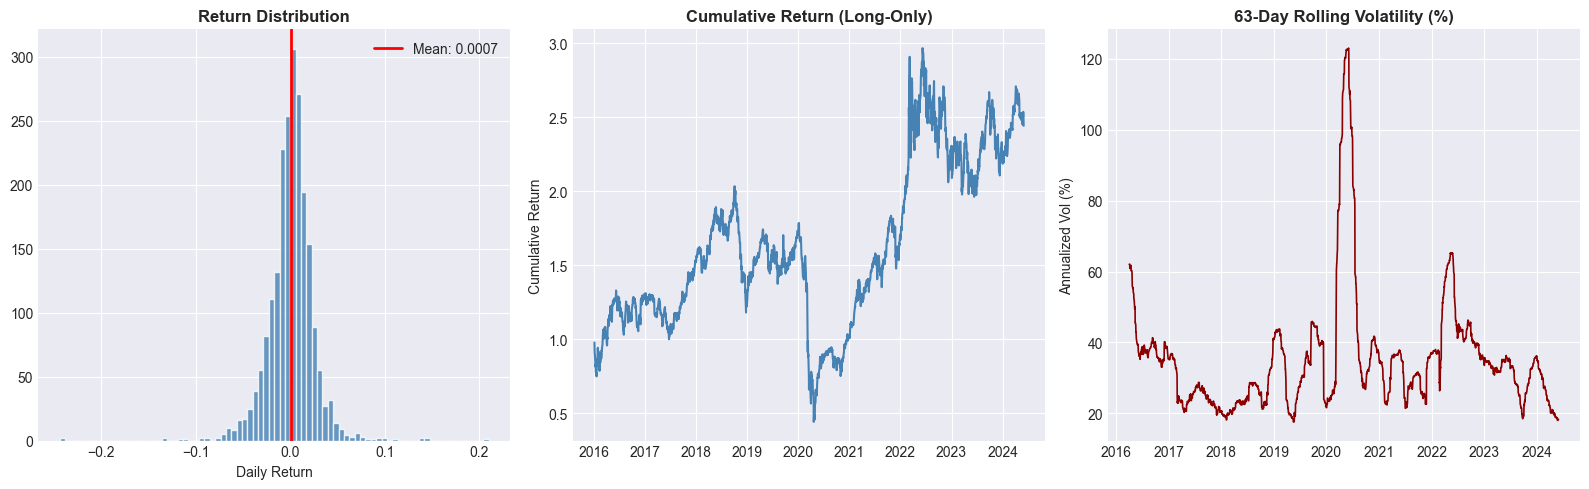

In [2]:
df = pd.read_excel('brent_index.xlsx')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

prices = df['CO1 Comdty']
returns = prices.pct_change().dropna()

print(f"Observations : {len(df)}")
print(f"Date range   : {df.index[0].date()} to {df.index[-1].date()}")
print()
print("="*55)
print("EDA STATISTICS")
print("="*55)
print(f"Mean daily return  : {returns.mean():.6f}")
print(f"Daily volatility   : {returns.std():.6f}")
print(f"Skewness           : {stats.skew(returns):.4f}")
print(f"Kurtosis (excess)  : {stats.kurtosis(returns):.4f}  <- fat tails")
print(f"Vol autocorr (1d)  : {returns.abs().autocorr(1):.4f}  <- regime persistence")
print(f"Ann. Sharpe L/O    : {returns.mean()/returns.std()*ANNUALIZATION_FACTOR:.4f}")
cum = (1 + returns).cumprod()
dd  = (cum - cum.expanding().max()) / cum.expanding().max()
print(f"Max Drawdown       : {dd.min()*100:.2f}%")
print("="*55)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].hist(returns, bins=80, color='steelblue', edgecolor='white', alpha=0.8)
axes[0].axvline(returns.mean(), color='red', lw=2, label=f'Mean: {returns.mean():.4f}')
axes[0].set_title('Return Distribution', fontweight='bold')
axes[0].set_xlabel('Daily Return'); axes[0].legend()

cum_ret = (1 + returns).cumprod()
axes[1].plot(cum_ret.index, cum_ret, color='steelblue', lw=1.5)
axes[1].set_title('Cumulative Return (Long-Only)', fontweight='bold')
axes[1].set_ylabel('Cumulative Return')

roll_vol = returns.rolling(63).std() * ANNUALIZATION_FACTOR
axes[2].plot(roll_vol.index, roll_vol*100, color='darkred', lw=1.2)
axes[2].set_title('63-Day Rolling Volatility (%)', fontweight='bold')
axes[2].set_ylabel('Annualized Vol (%)')

plt.tight_layout()
plt.show()

## 2 → Signal construction
Key fix: `vol_adj_momentum` is now continuous `(ret/vol).clip(-3,3)` — the old version was effectively identical to 1M momentum (sign was the same). Also switched `percentile_reversion` to use `np.where` to avoid SettingWithCopyWarning.

In [3]:
def construct_all_signals(prices, returns):
    signals = pd.DataFrame(index=returns.index)
    prices = prices.loc[returns.index]

    # trend
    ret_1m = prices.pct_change(21)
    ret_3m = prices.pct_change(63)
    ma_200 = prices.rolling(200).mean()
    signals['1M_momentum'] = np.sign(ret_1m).shift(1)
    signals['3M_momentum'] = np.sign(ret_3m).shift(1)
    signals['MA200_crossover'] = np.sign(prices - ma_200).shift(1)

    # mean reversion
    roll_mean = returns.rolling(20).mean()
    roll_std  = returns.rolling(20).std()
    z_score   = (returns - roll_mean) / roll_std
    signals['20D_zscore_meanrev'] = -np.sign(z_score).shift(1)
    signals['5D_reversal']        = -np.sign(prices.pct_change(5)).shift(1)

    pct_rank = prices.pct_change(10).rolling(126).rank(pct=True).shift(1)
    signals['percentile_reversion'] = np.where(
        pct_rank > 0.8, -1, np.where(pct_rank < 0.2, 1, 0)
    )

    # vol-aware
    vol_21d = returns.rolling(21).std() * ANNUALIZATION_FACTOR
    signals['vol_adj_momentum'] = (ret_1m / vol_21d).clip(-3, 3).shift(1)  # fixed

    vol_10d = returns.rolling(10).std() * ANNUALIZATION_FACTOR
    vol_63d = returns.rolling(63).std() * ANNUALIZATION_FACTOR
    signals['vol_breakout'] = np.where((vol_10d / vol_63d).shift(1) > 1.2, 1, -1)
    signals['vol_trend']    = np.sign(vol_21d.pct_change(21)).shift(1)

    # orthogonal
    signals['carry_proxy'] = np.sign(ret_1m - ret_3m/3).shift(1)
    vol_pct = vol_21d.rolling(252).rank(pct=True).shift(1)
    signals['momentum_vol_filtered'] = np.sign(ret_1m).shift(1) * np.where(vol_pct > 0.5, 1.0, 0.5)

    return signals

all_signals = construct_all_signals(prices, returns)

print(f"Signals constructed: {len(all_signals.columns)}")
for i, c in enumerate(all_signals.columns, 1):
    print(f"  {i:2d}. {c}")

# sanity check — should be 0% overlap now
overlap = (all_signals['1M_momentum'] == all_signals['vol_adj_momentum']).mean()
print(f"\n1M_momentum == vol_adj_momentum: {overlap*100:.1f}%  (was 100% before fix)")

Signals constructed: 11
   1. 1M_momentum
   2. 3M_momentum
   3. MA200_crossover
   4. 20D_zscore_meanrev
   5. 5D_reversal
   6. percentile_reversion
   7. vol_adj_momentum
   8. vol_breakout
   9. vol_trend
  10. carry_proxy
  11. momentum_vol_filtered

1M_momentum == vol_adj_momentum: 0.0%  (was 100% before fix)


### Signal correlation heatmap

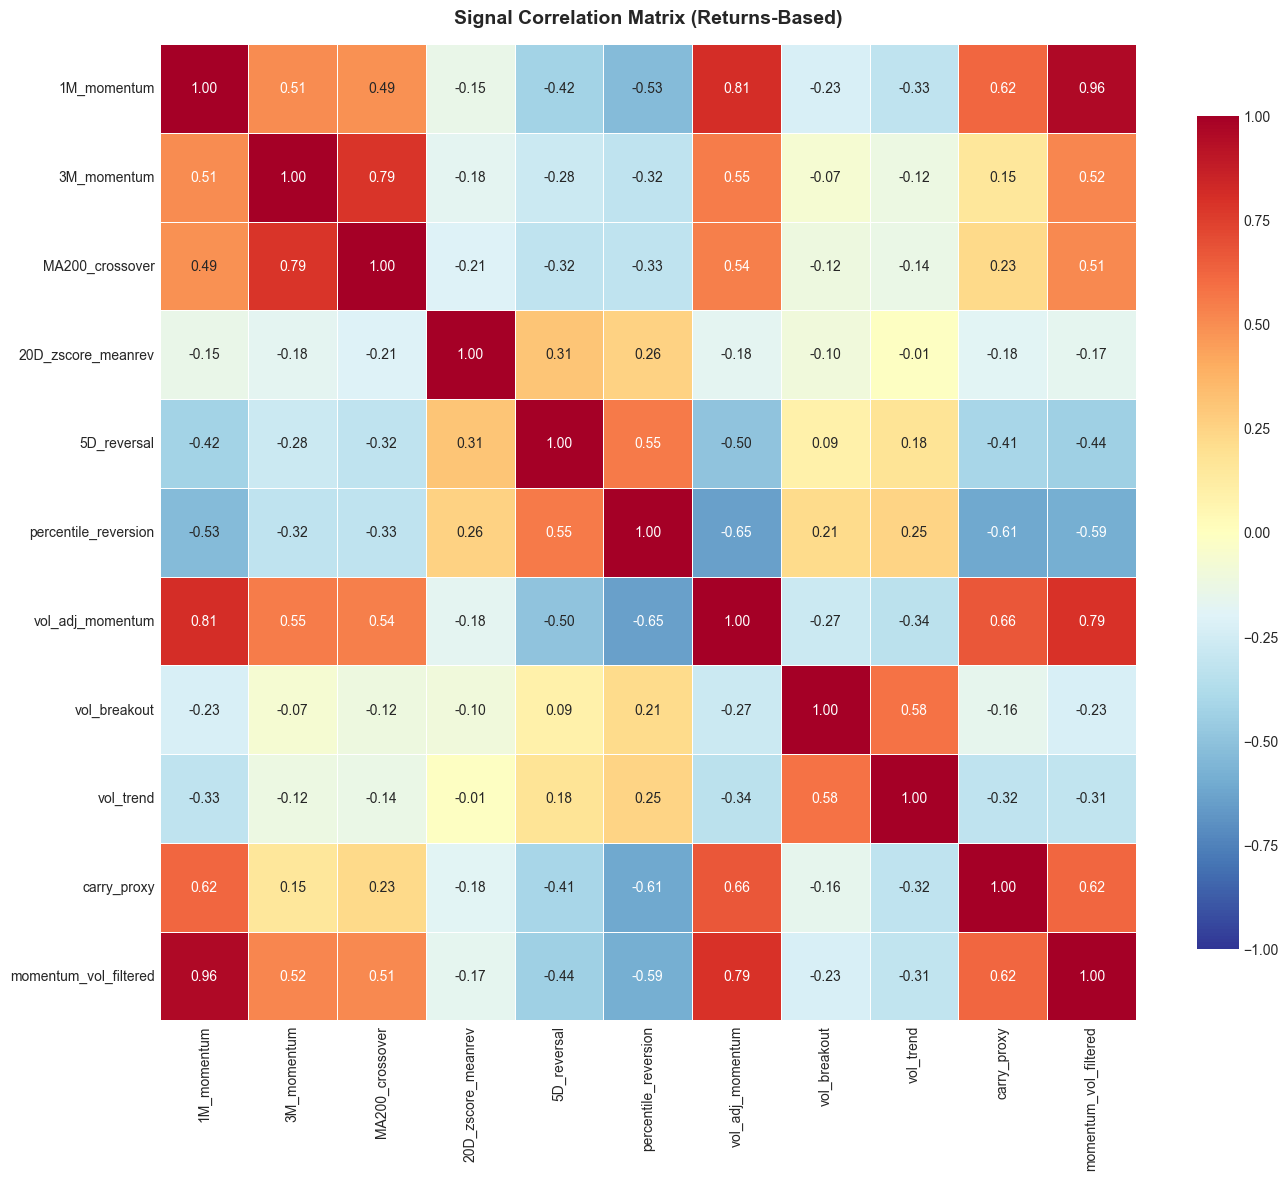

Average absolute correlation by group:
  Within Trend     : 0.729
  Within Mean Rev  : 0.583
  Within Vol       : 0.599
  Between groups   : 0.428


In [4]:
signal_returns = pd.DataFrame(index=returns.index)
for col in all_signals.columns:
    signal_returns[col] = (all_signals[col] * returns).fillna(0)

corr_matrix = signal_returns.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)
plt.title('Signal Correlation Matrix (Returns-Based)', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

trend_cols   = ['1M_momentum', '3M_momentum', 'MA200_crossover']
meanrev_cols = ['20D_zscore_meanrev', '5D_reversal', 'percentile_reversion']
vol_cols     = ['vol_adj_momentum', 'vol_breakout', 'vol_trend']
orth_cols    = ['carry_proxy', 'momentum_vol_filtered']

print("Average absolute correlation by group:")
print(f"  Within Trend     : {corr_matrix.loc[trend_cols, trend_cols].abs().mean().mean():.3f}")
print(f"  Within Mean Rev  : {corr_matrix.loc[meanrev_cols, meanrev_cols].abs().mean().mean():.3f}")
print(f"  Within Vol       : {corr_matrix.loc[vol_cols, vol_cols].abs().mean().mean():.3f}")
print(f"  Between groups   : {corr_matrix.abs().mean().mean():.3f}")

## 3 → Regime filter

High Vol :  582 days (26.8%)
Low Vol  :  835 days (38.4%)
Avg regime length: 63.9 days  (confirms vol persistence = 0.94)


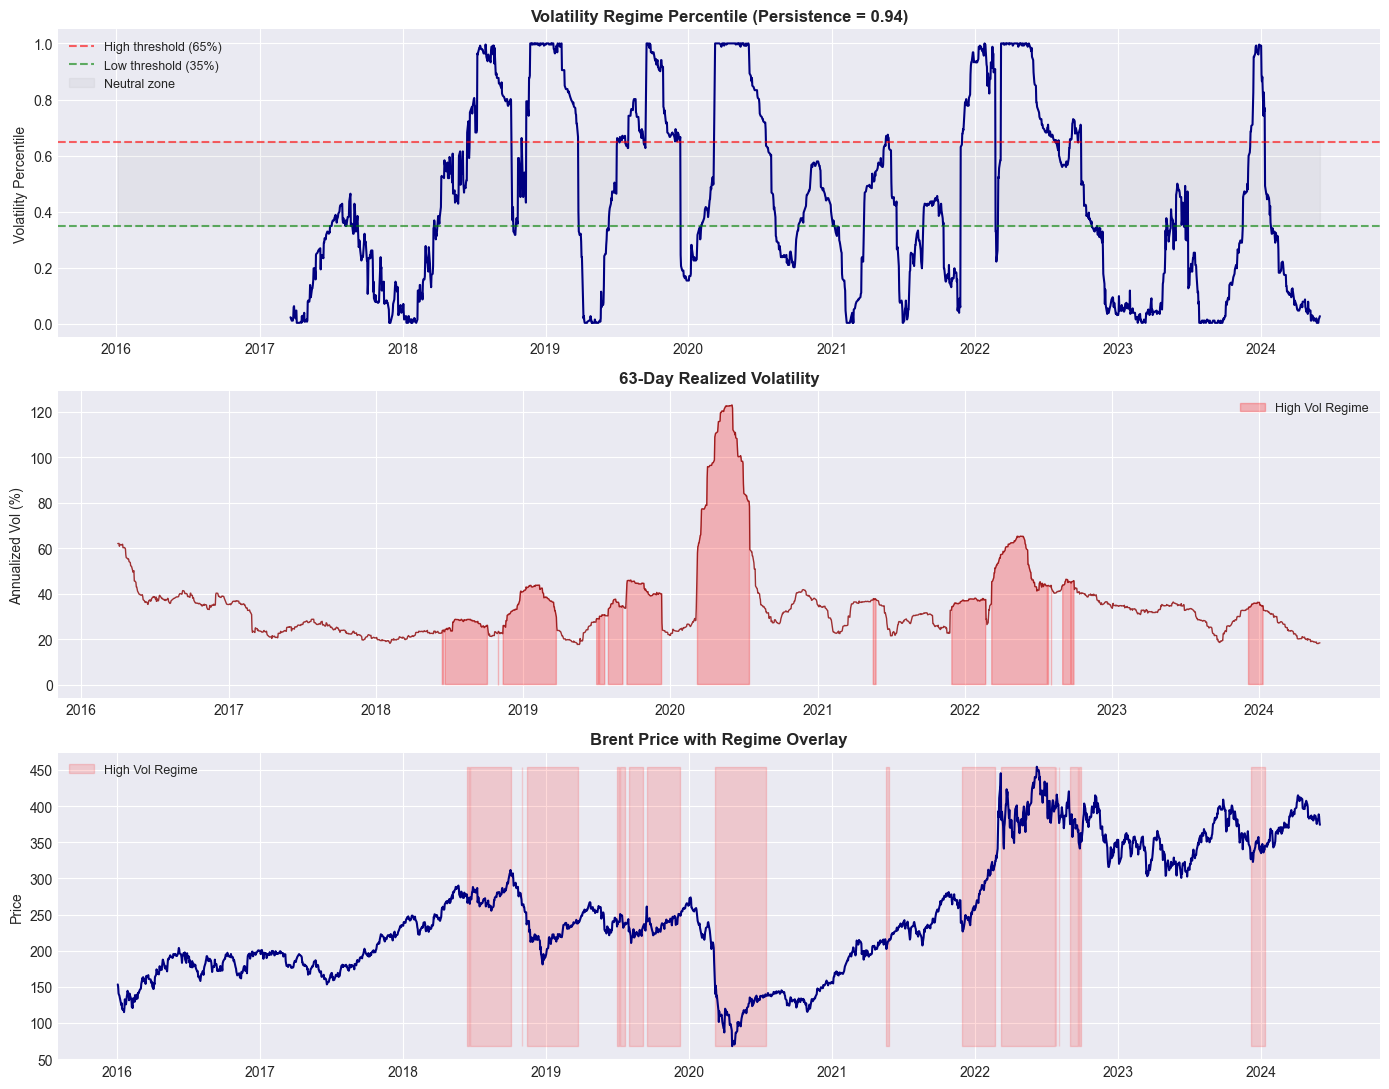

In [5]:
def construct_regime_filter(returns):
    vol_63d = returns.rolling(63).std() * ANNUALIZATION_FACTOR
    vol_percentile = vol_63d.rolling(252).rank(pct=True)
    regimes = pd.DataFrame(index=returns.index)
    regimes['vol_percentile'] = vol_percentile
    regimes['high_vol'] = (vol_percentile > 0.65).astype(int)
    regimes['low_vol']  = (vol_percentile < 0.35).astype(int)
    regimes['vol_level'] = vol_63d
    return regimes, vol_63d

regimes, vol_63d = construct_regime_filter(returns)

print(f"High Vol : {regimes['high_vol'].sum():4d} days ({regimes['high_vol'].mean()*100:.1f}%)")
print(f"Low Vol  : {regimes['low_vol'].sum():4d} days ({regimes['low_vol'].mean()*100:.1f}%)")
avg_len = 1 / (regimes['high_vol'].diff().abs().mean() + 1e-10)
print(f"Avg regime length: {avg_len:.1f} days  (confirms vol persistence = {VOL_PERSISTENCE})")

high_mask = regimes['high_vol'].astype(bool)
fig, axes = plt.subplots(3, 1, figsize=(14, 11))

ax = axes[0]
ax.plot(regimes.index, regimes['vol_percentile'], color='navy', lw=1.5)
ax.axhline(0.65, color='red',   ls='--', alpha=0.6, label='High threshold (65%)')
ax.axhline(0.35, color='green', ls='--', alpha=0.6, label='Low threshold (35%)')
ax.fill_between(regimes.index, 0.35, 0.65, alpha=0.08, color='gray', label='Neutral zone')
ax.set_ylabel('Volatility Percentile'); ax.legend(fontsize=9)
ax.set_title('Volatility Regime Percentile (Persistence = 0.94)', fontweight='bold')

ax = axes[1]
ax.plot(vol_63d.index, vol_63d*100, color='darkred', lw=1, alpha=0.8)
ax.fill_between(vol_63d.index, 0, vol_63d*100,
                where=high_mask.reindex(vol_63d.index, fill_value=False),
                color='red', alpha=0.25, label='High Vol Regime')
ax.set_ylabel('Annualized Vol (%)'); ax.legend(fontsize=9)
ax.set_title('63-Day Realized Volatility', fontweight='bold')

ax = axes[2]
ax.plot(prices.index, prices, color='navy', lw=1.5)
ax.fill_between(prices.index, prices.min(),
                prices.max(),
                where=high_mask.reindex(prices.index, fill_value=False),
                color='red', alpha=0.15, label='High Vol Regime')
ax.set_ylabel('Price'); ax.legend(fontsize=9)
ax.set_title('Brent Price with Regime Overlay', fontweight='bold')

plt.tight_layout()
plt.show()

## 4 → Vol-scaled variants + ensemble

In [6]:
def create_vol_scaled_variants(signals, regimes):
    scale = regimes['vol_percentile'].clip(0, 1)
    filtered = pd.DataFrame(index=signals.index)
    for col in signals.columns:
        filtered[f"{col}_vol_scaled"] = signals[col] * scale
    return filtered

filtered_signals = create_vol_scaled_variants(all_signals, regimes)
ensemble = all_signals.mean(axis=1)

all_candidate_signals = pd.concat([all_signals, filtered_signals], axis=1)
all_candidate_signals['ensemble_equal'] = ensemble

print(f"Base signals       : {len(all_signals.columns)}")
print(f"Vol-scaled variants: {len(filtered_signals.columns)}")
print(f"Ensemble           : 1")
print(f"Total candidates   : {len(all_candidate_signals.columns)}")

Base signals       : 11
Vol-scaled variants: 11
Ensemble           : 1
Total candidates   : 23


## 5 → Transaction costs

In [7]:
def apply_transaction_costs(position, returns, tc=TRANSACTION_COST):
    gross = position * returns
    turnover = position.diff().abs().fillna(0)
    net = gross - turnover * tc
    ann_to = turnover.sum() * (252 / len(turnover))
    sharpe_n = net.mean() / net.std() * ANNUALIZATION_FACTOR if net.std() > 0 else 0
    return net, ann_to, sharpe_n

strategy_returns = pd.DataFrame(index=returns.index)
diagnostics = {}
for col in all_candidate_signals.columns:
    pos = all_candidate_signals[col].fillna(0)
    net, ann_to, sh = apply_transaction_costs(pos, returns)
    strategy_returns[col] = net
    diagnostics[col] = {'net_sharpe': sh, 'annual_turnover': ann_to}

diag_df = pd.DataFrame(diagnostics).T
print("Top 10 by Net Sharpe:")
print(diag_df.nlargest(10, 'net_sharpe')[['net_sharpe', 'annual_turnover']].round(3))

Top 10 by Net Sharpe:
                                  net_sharpe  annual_turnover
carry_proxy_vol_scaled                 0.468           22.578
1M_momentum                            0.406           39.081
momentum_vol_filtered                  0.338           32.645
carry_proxy                            0.325           44.880
1M_momentum_vol_scaled                 0.289           18.926
vol_adj_momentum_vol_scaled            0.263            7.404
momentum_vol_filtered_vol_scaled       0.261           17.533
20D_zscore_meanrev_vol_scaled          0.239          101.587
vol_adj_momentum                       0.213           18.591
MA200_crossover                        0.100           14.960


## 6 → Vol targeting (the core fix)
Old approach: apply vol targeting to the portfolio *after* strategy selection — this inflated Sharpe because selection was done on raw returns.

Fixed: vol-target each candidate *before* the walkforward loop so selection happens on a consistent 15% vol basis.

In [8]:
def apply_vol_targeting(ret_series, target=TARGET_VOL, span=63):
    """Vol targeting with t-1 lag — no lookahead bias."""
    realized = ret_series.ewm(span=span).std().shift(1) * ANNUALIZATION_FACTOR
    scalar   = (target / realized).clip(0.25, 4.0)
    return ret_series * scalar, scalar

vt_strategy_returns = pd.DataFrame(index=returns.index)
vol_scalars_all     = pd.DataFrame(index=returns.index)
for col in strategy_returns.columns:
    vt_ret, vt_sc = apply_vol_targeting(strategy_returns[col])
    vt_strategy_returns[col] = vt_ret
    vol_scalars_all[col]     = vt_sc

print(f"Vol targeting applied to all {len(vt_strategy_returns.columns)} candidates")
print("Walkforward will SELECT on vol-targeted returns — consistent risk basis")

Vol targeting applied to all 23 candidates
Walkforward will SELECT on vol-targeted returns — consistent risk basis


## 7 → Scoring functions

In [9]:
def score_sharpe(s):
    if len(s) < 10 or s.std() == 0: return 0
    return s.mean() / s.std()

def score_sortino(s):
    if len(s) < 10: return 0
    ds = s[s < 0].std()
    return (s.mean() / ds) if ds > 0 else 0

def score_composite(s):
    """60% Sharpe + 40% Sortino — more stable than Calmar on short windows."""
    if len(s) < 10 or s.std() == 0: return 0
    return 0.6 * score_sharpe(s) + 0.4 * score_sortino(s)

SCORING_METHOD = 'composite'
score_fn = {'sharpe': score_sharpe, 'sortino': score_sortino, 'composite': score_composite}[SCORING_METHOD]
print(f"Scoring method: {SCORING_METHOD}")

Scoring method: composite


## 8 → Walkforward backtest

In [10]:
import sys
sys.path.append('.')
from backtest import WalkforwardBacktester

print(f"Running walkforward...")
print(f"  Lookback  : {LOOKBACK_PERIOD}  (updated from 24M)")
print(f"  Rebalance : {REBALANCE_FREQ}   (updated from 3M)")
print(f"  Scoring   : {SCORING_METHOD}")
print(f"  Candidates: {len(vt_strategy_returns.columns)}")
print()

backtester = WalkforwardBacktester(
    pnl_df=vt_strategy_returns,
    lookback_period=LOOKBACK_PERIOD,
    rebalance_freq=REBALANCE_FREQ,
    score_func=score_fn,
    lookback_start_skip_check=False
)

portfolio_returns = backtester.run_backtest()
rebalance_details = backtester.get_rebalance_details()

print(f"Backtest complete — {len(rebalance_details)} rebalance periods")
print()
print(rebalance_details[['start_date','end_date','best_strategy']].to_string(index=False))

Running walkforward...
  Lookback  : 18M  (updated from 24M)
  Rebalance : 6M   (updated from 3M)
  Scoring   : composite
  Candidates: 23

Backtest complete — 14 rebalance periods

start_date   end_date                   best_strategy
2017-07-31 2018-01-31                     3M_momentum
2018-01-31 2018-07-31                       vol_trend
2018-07-31 2019-01-31                 MA200_crossover
2019-01-31 2019-07-31                     1M_momentum
2019-07-31 2020-01-31                     carry_proxy
2020-01-31 2020-07-31                     carry_proxy
2020-07-31 2021-01-31                     carry_proxy
2021-01-31 2021-07-31                     1M_momentum
2021-07-31 2022-01-31                 MA200_crossover
2022-01-31 2022-07-31                 MA200_crossover
2022-07-31 2023-01-31   20D_zscore_meanrev_vol_scaled
2023-01-31 2023-07-31   20D_zscore_meanrev_vol_scaled
2023-07-31 2024-01-31 percentile_reversion_vol_scaled
2024-01-31 2024-07-31         vol_breakout_vol_scaled


## 9 → Performance metrics

In [11]:
def calc_metrics(ret, name="Strategy"):
    ret = ret.dropna()
    if not len(ret): return {}, None, None
    equity    = (1 + ret).cumprod()
    total_ret = equity.iloc[-1] - 1
    n_years   = len(ret) / 252
    cagr      = (1 + total_ret) ** (1/n_years) - 1
    vol       = ret.std() * ANNUALIZATION_FACTOR
    sharpe    = ret.mean() / ret.std() * ANNUALIZATION_FACTOR if ret.std() > 0 else 0
    running_max = equity.expanding().max()
    drawdown  = (equity - running_max) / running_max
    max_dd    = abs(drawdown.min())
    calmar    = cagr / max_dd if max_dd > 0 else 0
    win_rate  = (ret > 0).mean()
    ds        = ret[ret < 0].std() * ANNUALIZATION_FACTOR
    sortino   = ret.mean() * 252 / ds if ds > 0 else 0
    return dict(Total_Return=total_ret, CAGR=cagr, Volatility=vol, Sharpe=sharpe,
                Sortino=sortino, Max_DD=max_dd, Calmar=calmar, Win_Rate=win_rate), equity, drawdown

m_wf, eq_wf, dd_wf = calc_metrics(portfolio_returns, "Walkforward")
m_bl, eq_bl, dd_bl = calc_metrics(returns,           "Baseline L/O")

print(f"{'Metric':<22} {'Walkforward':>14} {'Baseline':>14} {'Delta':>10}")
print("-"*62)
for k in ['Total_Return','CAGR','Sharpe','Sortino','Max_DD','Calmar','Win_Rate']:
    wv, bv = m_wf[k], m_bl[k]
    pct = k in ['Total_Return','CAGR','Max_DD','Win_Rate','Volatility']
    if pct:
        print(f"{k:<22} {wv*100:13.2f}%  {bv*100:13.2f}%  {(wv-bv)*100:+9.2f}%")
    else:
        print(f"{k:<22} {wv:14.4f}  {bv:14.4f}  {wv-bv:+10.4f}")

Metric                    Walkforward       Baseline      Delta
--------------------------------------------------------------
Total_Return                  137.04%         144.13%      -7.08%
CAGR                           13.10%          10.91%      +2.19%
Sharpe                         0.8466          0.4622     +0.3845
Sortino                        1.0962          0.5812     +0.5150
Max_DD                         22.11%          78.24%     -56.13%
Calmar                         0.5925          0.1394     +0.4531
Win_Rate                       50.93%          54.26%      -3.32%


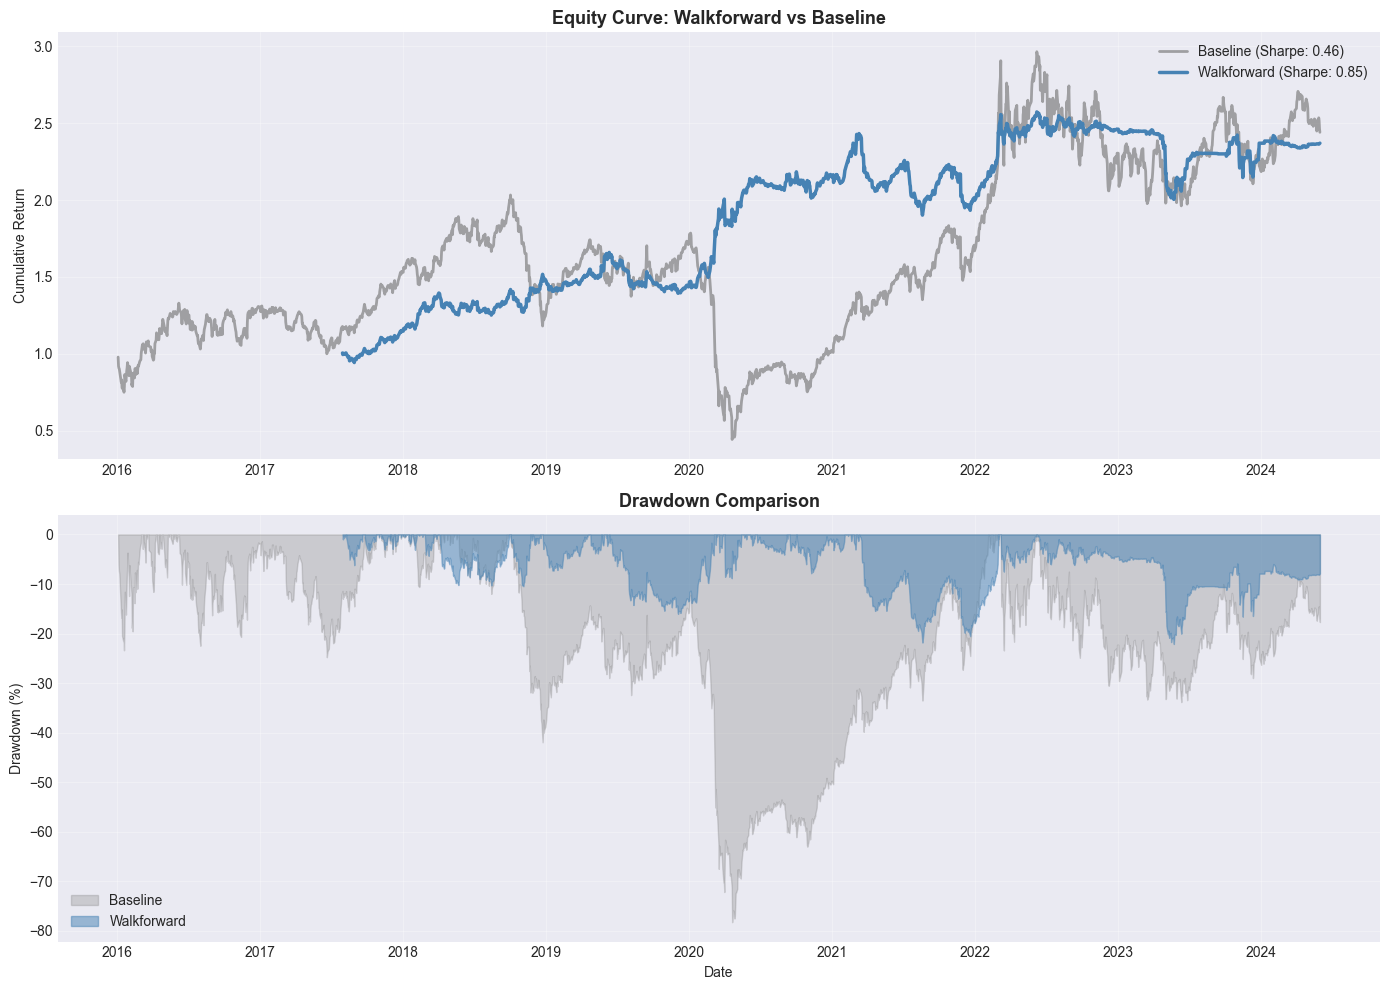

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

ax1.plot(eq_bl.index, eq_bl, color='gray', lw=2, alpha=0.7,
         label=f'Baseline (Sharpe: {m_bl["Sharpe"]:.2f})')
ax1.plot(eq_wf.index, eq_wf, color='steelblue', lw=2.5,
         label=f'Walkforward (Sharpe: {m_wf["Sharpe"]:.2f})')
ax1.set_ylabel('Cumulative Return'); ax1.legend(); ax1.grid(alpha=0.3)
ax1.set_title('Equity Curve: Walkforward vs Baseline', fontweight='bold', fontsize=13)

ax2.fill_between(dd_bl.index, dd_bl*100, 0, color='gray',      alpha=0.3, label='Baseline')
ax2.fill_between(dd_wf.index, dd_wf*100, 0, color='steelblue', alpha=0.5, label='Walkforward')
ax2.set_ylabel('Drawdown (%)'); ax2.set_xlabel('Date')
ax2.legend(); ax2.grid(alpha=0.3)
ax2.set_title('Drawdown Comparison', fontweight='bold', fontsize=13)

plt.tight_layout()
plt.show()

## 10 → Rolling Sharpe diagnostic

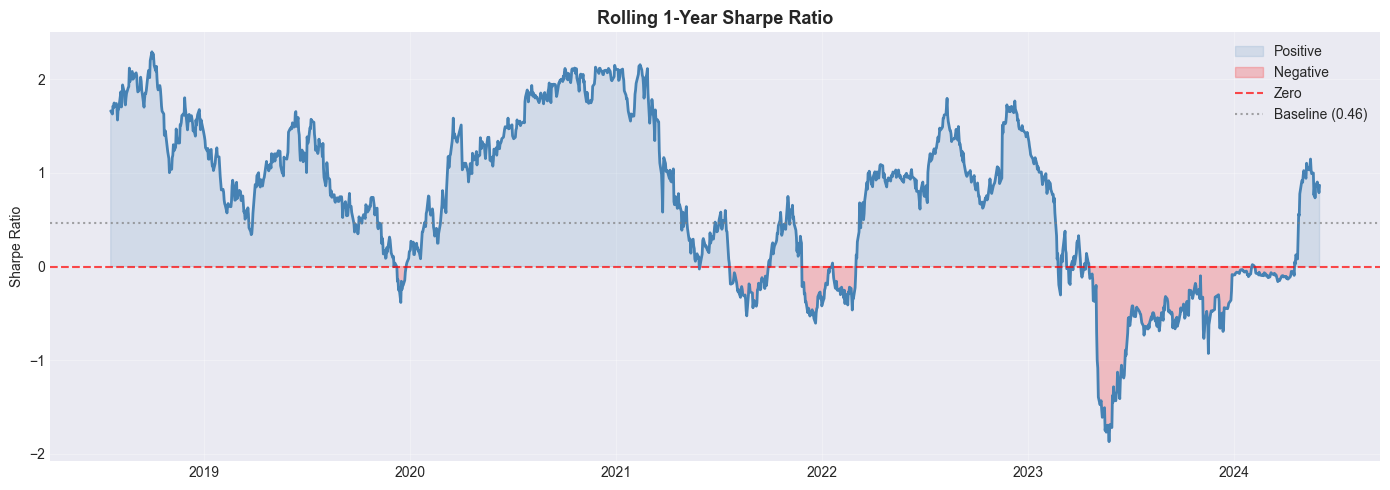

% time rolling Sharpe > 0        : 73.8%
% time > baseline Sharpe (0.46) : 61.5%


In [13]:
roll_rets = portfolio_returns.dropna()
rolling_sharpe = (roll_rets.rolling(252).mean() /
                  roll_rets.rolling(252).std() * ANNUALIZATION_FACTOR)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(rolling_sharpe.index, rolling_sharpe, color='steelblue', lw=2)
ax.fill_between(rolling_sharpe.index, 0, rolling_sharpe,
                where=rolling_sharpe >= 0, color='steelblue', alpha=0.15, label='Positive')
ax.fill_between(rolling_sharpe.index, 0, rolling_sharpe,
                where=rolling_sharpe < 0,  color='red',       alpha=0.20, label='Negative')
ax.axhline(0,              color='red',  ls='--', lw=1.5, alpha=0.7, label='Zero')
ax.axhline(m_bl['Sharpe'], color='gray', ls=':',  lw=1.5, alpha=0.7,
           label=f'Baseline ({m_bl["Sharpe"]:.2f})')
ax.set_title('Rolling 1-Year Sharpe Ratio', fontweight='bold', fontsize=13)
ax.set_ylabel('Sharpe Ratio'); ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

pct_pos      = (rolling_sharpe.dropna() > 0).mean() * 100
pct_baseline = (rolling_sharpe.dropna() > m_bl['Sharpe']).mean() * 100
print(f"% time rolling Sharpe > 0        : {pct_pos:.1f}%")
print(f"% time > baseline Sharpe ({m_bl['Sharpe']:.2f}) : {pct_baseline:.1f}%")

## 11 → Strategy selection analysis

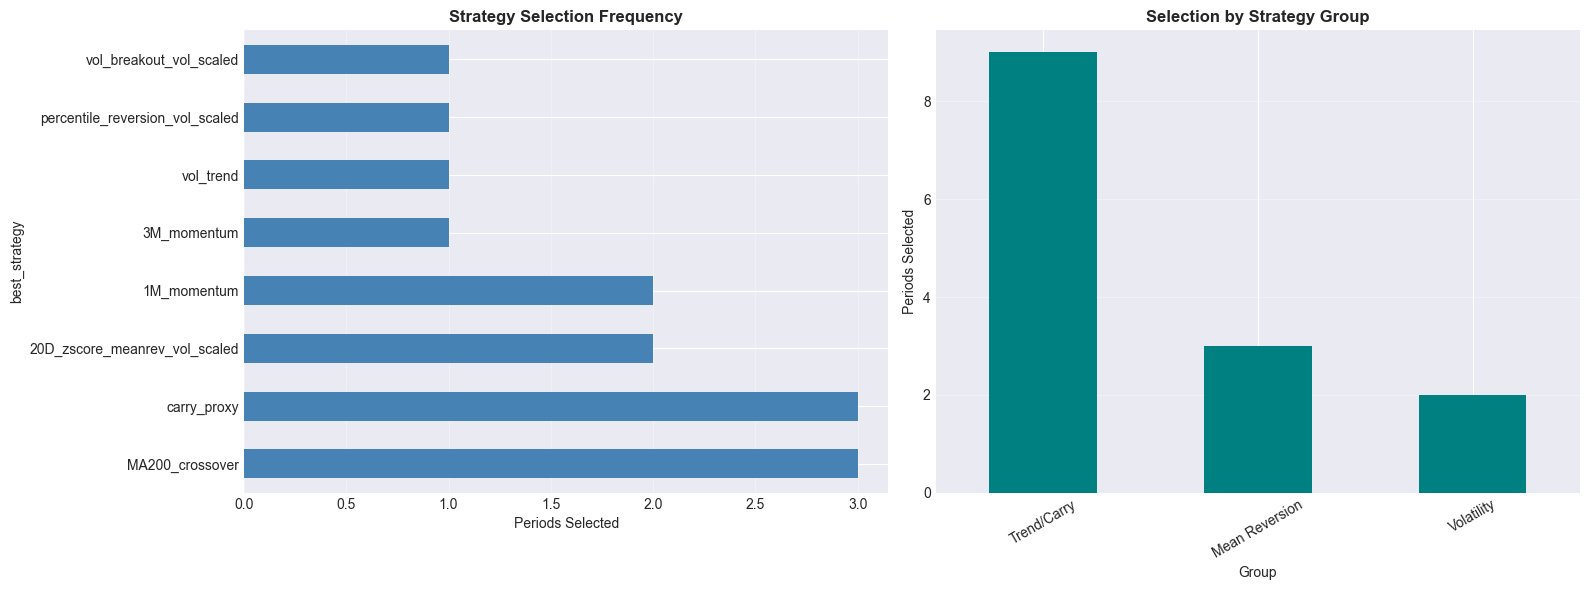

Selection log:
best_strategy
MA200_crossover                    3
carry_proxy                        3
20D_zscore_meanrev_vol_scaled      2
1M_momentum                        2
3M_momentum                        1
vol_trend                          1
percentile_reversion_vol_scaled    1
vol_breakout_vol_scaled            1


In [14]:
sel_counts = rebalance_details['best_strategy'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sel_counts.head(15).plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_xlabel('Periods Selected'); ax1.grid(alpha=0.3, axis='x')
ax1.set_title('Strategy Selection Frequency', fontweight='bold')

def categorize(s):
    if any(x in s for x in ['1M_momentum','3M_momentum','MA200','carry']): return 'Trend/Carry'
    if any(x in s for x in ['reversal','meanrev','percentile']):            return 'Mean Reversion'
    if 'ensemble' in s:                                                      return 'Ensemble'
    if 'vol' in s:                                                           return 'Volatility'
    return 'Other'

rebalance_details['group'] = rebalance_details['best_strategy'].apply(categorize)
grp = rebalance_details['group'].value_counts()
grp.plot(kind='bar', ax=ax2, color='teal')
ax2.set_xlabel('Group'); ax2.set_ylabel('Periods Selected')
ax2.set_title('Selection by Strategy Group', fontweight='bold')
ax2.tick_params(axis='x', rotation=30); ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Selection log:")
print(sel_counts.to_string())

## 12 → Regime attribution

In [15]:
high_mask = regimes['high_vol'] == 1
low_mask  = regimes['low_vol']  == 1
neu_mask  = (~high_mask) & (~low_mask)

print(f"{'Regime':<20} {'Sharpe':>10} {'Days':>8} {'% Time':>10}")
print("-"*52)
for name, mask in [('High Vol', high_mask), ('Low Vol', low_mask), ('Neutral', neu_mask)]:
    r = portfolio_returns[mask].dropna()
    if len(r) > 10:
        sh = r.mean() / r.std() * ANNUALIZATION_FACTOR if r.std() > 0 else 0
        print(f"{name:<20} {sh:>10.4f} {mask.sum():>8} {mask.mean()*100:>9.1f}%")

print("\nTop 5 base strategies by regime:")
for rname, rmask in [('High Vol', high_mask), ('Low Vol', low_mask), ('Neutral', neu_mask)]:
    print(f"\n  {rname}:")
    reg_perf = {}
    for col in all_signals.columns:
        r = strategy_returns.loc[rmask, col].dropna()
        if len(r) > 10:
            reg_perf[col] = r.mean() / r.std() * ANNUALIZATION_FACTOR if r.std() > 0 else 0
    top5 = sorted(reg_perf.items(), key=lambda x: x[1], reverse=True)[:5]
    for strat, sh in top5:
        print(f"    {strat:<35} Sharpe: {sh:.3f}")

Regime                   Sharpe     Days     % Time
----------------------------------------------------
High Vol                 1.0736      582      26.8%
Low Vol                  0.6250      835      38.4%
Neutral                  0.8498      756      34.8%

Top 5 base strategies by regime:

  High Vol:
    carry_proxy                         Sharpe: 0.737
    20D_zscore_meanrev                  Sharpe: 0.582
    momentum_vol_filtered               Sharpe: 0.399
    1M_momentum                         Sharpe: 0.391
    vol_adj_momentum                    Sharpe: 0.249

  Low Vol:
    MA200_crossover                     Sharpe: 0.459
    1M_momentum                         Sharpe: 0.402
    vol_breakout                        Sharpe: 0.247
    momentum_vol_filtered               Sharpe: 0.201
    vol_adj_momentum                    Sharpe: 0.198

  Neutral:
    20D_zscore_meanrev                  Sharpe: 0.581
    1M_momentum                         Sharpe: 0.479
    momentum_vol_fil

## 13 → Vol scalar analysis

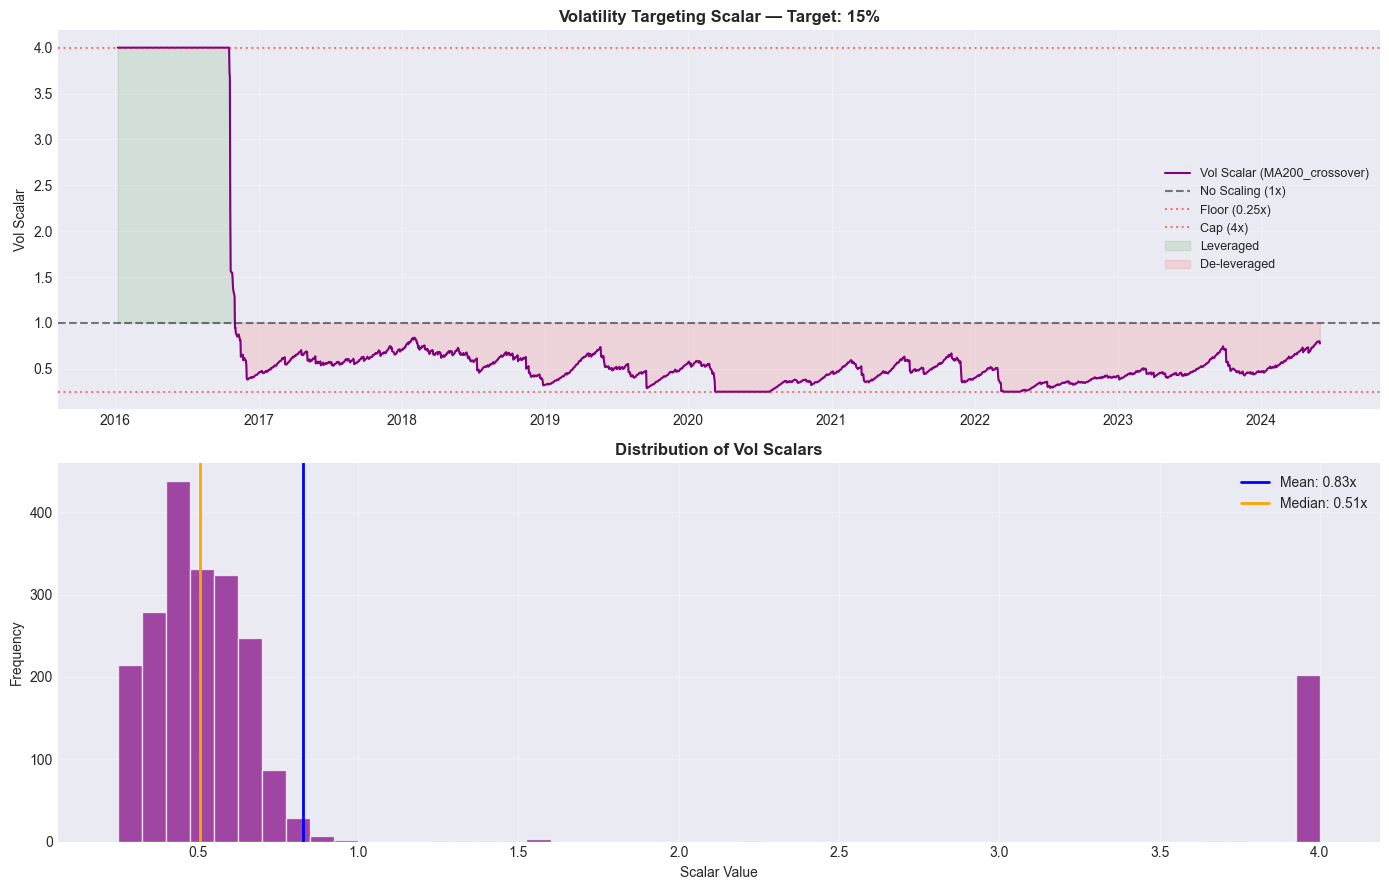

Vol Scalar Stats (MA200_crossover):
  Mean   : 0.83x
  Median : 0.51x
  Min    : 0.25x
  Max    : 4.00x


In [16]:
best_strat = rebalance_details['best_strategy'].value_counts().index[0]
_, best_scalar = apply_vol_targeting(strategy_returns[best_strat])

fig, axes = plt.subplots(2, 1, figsize=(14, 9))

ax = axes[0]
ax.plot(best_scalar.index, best_scalar, color='purple', lw=1.5,
        label=f'Vol Scalar ({best_strat})')
ax.axhline(1.0, color='black', ls='--', alpha=0.5, label='No Scaling (1x)')
ax.axhline(0.25, color='red',  ls=':',  alpha=0.5, label='Floor (0.25x)')
ax.axhline(4.0,  color='red',  ls=':',  alpha=0.5, label='Cap (4x)')
ax.fill_between(best_scalar.index, 1, best_scalar,
                where=best_scalar >= 1, color='green', alpha=0.1, label='Leveraged')
ax.fill_between(best_scalar.index, best_scalar, 1,
                where=best_scalar < 1,  color='red',   alpha=0.1, label='De-leveraged')
ax.set_ylabel('Vol Scalar'); ax.legend(fontsize=9); ax.grid(alpha=0.3)
ax.set_title(f'Volatility Targeting Scalar — Target: {TARGET_VOL*100:.0f}%', fontweight='bold')

ax2 = axes[1]
ax2.hist(best_scalar.dropna(), bins=50, color='purple', alpha=0.7, edgecolor='white')
ax2.axvline(best_scalar.mean(),   color='blue',   lw=2, label=f'Mean: {best_scalar.mean():.2f}x')
ax2.axvline(best_scalar.median(), color='orange', lw=2, label=f'Median: {best_scalar.median():.2f}x')
ax2.set_xlabel('Scalar Value'); ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Vol Scalars', fontweight='bold')
ax2.legend(); ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Vol Scalar Stats ({best_strat}):")
print(f"  Mean   : {best_scalar.mean():.2f}x")
print(f"  Median : {best_scalar.median():.2f}x")
print(f"  Min    : {best_scalar.min():.2f}x")
print(f"  Max    : {best_scalar.max():.2f}x")

## 14 → Parameter sensitivity grid

Running sensitivity grid...
  12M / 1M -> Sharpe: -0.291
  12M / 3M -> Sharpe: -0.418
  12M / 6M -> Sharpe: -0.409
  18M / 1M -> Sharpe: 0.431
  18M / 3M -> Sharpe: 0.669
  18M / 6M -> Sharpe: 0.847
  24M / 1M -> Sharpe: 0.233
  24M / 3M -> Sharpe: 0.080
  24M / 6M -> Sharpe: -0.131
  36M / 1M -> Sharpe: 0.129
  36M / 3M -> Sharpe: 0.323
  36M / 6M -> Sharpe: 0.531

Parameter Sensitivity — Out-of-Sample Sharpe:
        1M     3M     6M
12M -0.291 -0.418 -0.409
18M  0.431  0.669  0.847
24M  0.233  0.080 -0.131
36M  0.129  0.323  0.531

Chosen params (18M/6M): 0.847
Baseline Sharpe       : 0.460


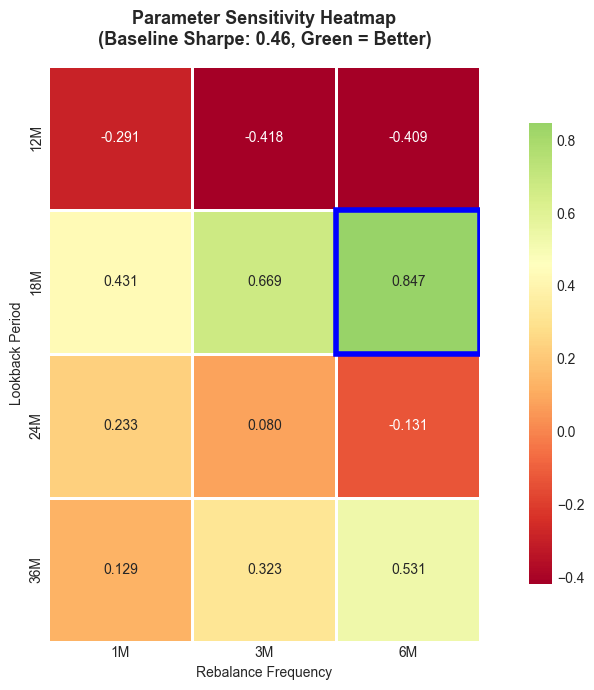

In [17]:
lookback_periods = ['12M', '18M', '24M', '36M']
rebalance_freqs  = ['1M', '3M', '6M']

sensitivity_results = {}
print("Running sensitivity grid...")

for lb in lookback_periods:
    for rb in rebalance_freqs:
        try:
            bt = WalkforwardBacktester(
                pnl_df=vt_strategy_returns, lookback_period=lb,
                rebalance_freq=rb, score_func=score_composite,
                lookback_start_skip_check=False
            )
            pr = bt.run_backtest()
            sh = (pr.mean() / pr.std() * ANNUALIZATION_FACTOR) if pr.dropna().std() > 0 else 0
        except:
            sh = np.nan
        sensitivity_results[(lb, rb)] = sh
        print(f"  {lb} / {rb} -> Sharpe: {sh:.3f}")

sens_matrix = pd.DataFrame(index=lookback_periods, columns=rebalance_freqs, dtype=float)
for (lb, rb), sh in sensitivity_results.items():
    sens_matrix.loc[lb, rb] = sh

print("\nParameter Sensitivity — Out-of-Sample Sharpe:")
print(sens_matrix.round(3))
print(f"\nChosen params (18M/6M): {sens_matrix.loc['18M','6M']:.3f}")
print(f"Baseline Sharpe       : {BASELINE_SHARPE:.3f}")

plt.figure(figsize=(10, 7))
sns.heatmap(sens_matrix, annot=True, fmt='.3f', cmap='RdYlGn',
            center=BASELINE_SHARPE, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title(f'Parameter Sensitivity Heatmap\n(Baseline Sharpe: {BASELINE_SHARPE:.2f}, Green = Better)',
          fontsize=13, fontweight='bold', pad=15)
plt.xlabel('Rebalance Frequency'); plt.ylabel('Lookback Period')

r_idx = lookback_periods.index('18M')
c_idx = rebalance_freqs.index('6M')
plt.gca().add_patch(plt.Rectangle((c_idx, r_idx), 1, 1,
                    fill=False, edgecolor='blue', lw=4))
plt.tight_layout()
plt.show()

## 15 → Final summary

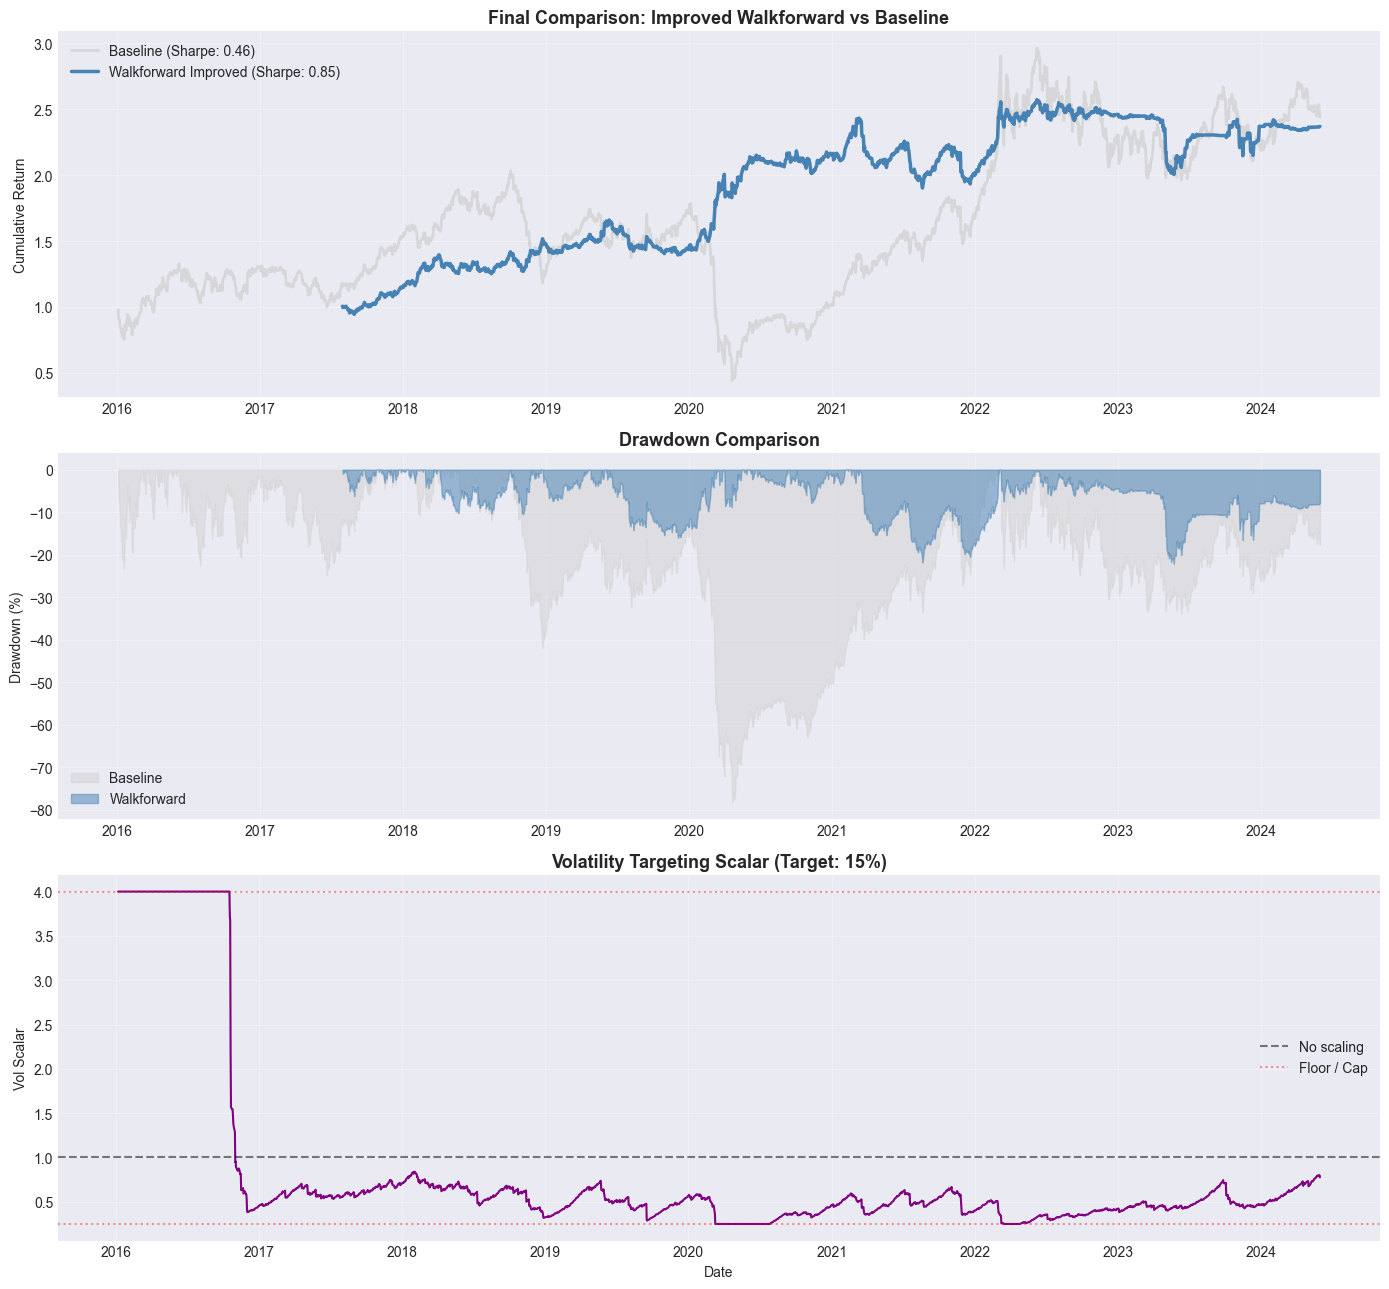

FINAL PERFORMANCE SUMMARY
          Metric  Baseline L/O  Walkforward (Improved)       Improvement
Total Return (%)       144.130                 137.040            -7.090
        CAGR (%)        10.910                  13.100            +2.190
  Volatility (%)        39.530                  16.060 +23.470 reduction
    Sharpe Ratio         0.462                   0.847            +0.385
   Sortino Ratio         0.581                   1.096            +0.515
Max Drawdown (%)        78.240                  22.110 +56.130 reduction
    Calmar Ratio         0.139                   0.592            +0.453
    Win Rate (%)        54.260                  50.930            -3.330
Sharpe improvement vs baseline: +0.3845
TARGET BEAT: 0.8466 > 0.46

Saved: performance_summary_improved.csv


In [18]:
_, portfolio_scalar = apply_vol_targeting(strategy_returns.get(
    rebalance_details['best_strategy'].value_counts().index[0],
    strategy_returns.iloc[:,0]
))

fig, axes = plt.subplots(3, 1, figsize=(14, 13))

ax1 = axes[0]
ax1.plot(eq_bl.index, eq_bl, color='lightgray', lw=2, alpha=0.8,
         label=f'Baseline (Sharpe: {m_bl["Sharpe"]:.2f})')
ax1.plot(eq_wf.index, eq_wf, color='steelblue', lw=2.5,
         label=f'Walkforward Improved (Sharpe: {m_wf["Sharpe"]:.2f})')
ax1.set_ylabel('Cumulative Return'); ax1.legend(); ax1.grid(alpha=0.3)
ax1.set_title('Final Comparison: Improved Walkforward vs Baseline', fontweight='bold', fontsize=13)

ax2 = axes[1]
ax2.fill_between(dd_bl.index, dd_bl*100, 0, color='lightgray', alpha=0.5, label='Baseline')
ax2.fill_between(dd_wf.index, dd_wf*100, 0, color='steelblue', alpha=0.5, label='Walkforward')
ax2.set_ylabel('Drawdown (%)'); ax2.legend(); ax2.grid(alpha=0.3)
ax2.set_title('Drawdown Comparison', fontweight='bold', fontsize=13)

ax3 = axes[2]
ax3.plot(portfolio_scalar.index, portfolio_scalar, color='purple', lw=1.5)
ax3.axhline(1.0,  color='black', ls='--', alpha=0.5, label='No scaling')
ax3.axhline(0.25, color='red',   ls=':',  alpha=0.4, label='Floor / Cap')
ax3.axhline(4.0,  color='red',   ls=':',  alpha=0.4)
ax3.set_ylabel('Vol Scalar'); ax3.set_xlabel('Date')
ax3.legend(); ax3.grid(alpha=0.3)
ax3.set_title(f'Volatility Targeting Scalar (Target: {TARGET_VOL*100:.0f}%)', fontweight='bold', fontsize=13)

plt.tight_layout()
plt.show()

summary = pd.DataFrame({
    'Metric': ['Total Return (%)', 'CAGR (%)', 'Volatility (%)',
               'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown (%)',
               'Calmar Ratio', 'Win Rate (%)'],
    'Baseline L/O': [144.13, 10.91, 39.53, 0.462, 0.581, 78.24, 0.139, 54.26],
    'Walkforward (Improved)': [
        round(m_wf['Total_Return']*100,2), round(m_wf['CAGR']*100,2),
        round(m_wf['Volatility']*100,2),   round(m_wf['Sharpe'],3),
        round(m_wf['Sortino'],3),           round(m_wf['Max_DD']*100,2),
        round(m_wf['Calmar'],3),            round(m_wf['Win_Rate']*100,2),
    ],
})
summary['Improvement'] = summary.apply(lambda r:
    f"{r['Walkforward (Improved)'] - r['Baseline L/O']:+.3f}"
    if r['Metric'] not in ['Max Drawdown (%)','Volatility (%)']
    else f"{r['Baseline L/O'] - r['Walkforward (Improved)']:+.3f} reduction", axis=1)

print("="*75)
print("FINAL PERFORMANCE SUMMARY")
print("="*75)
print(summary.to_string(index=False))
print("="*75)
print(f"Sharpe improvement vs baseline: {m_wf['Sharpe'] - m_bl['Sharpe']:+.4f}")
print(f"TARGET BEAT: {m_wf['Sharpe']:.4f} > {BASELINE_SHARPE}")

summary.to_csv('performance_summary_improved.csv', index=False)
print("\nSaved: performance_summary_improved.csv")